In [92]:
import csv
import html
import subprocess

table = "../../results/01_proc_reads/map_reads/summary_table"

html_top = """
<html>
  <head>
    <style>
      tr:nth-child(odd) { background-color: #fff; }
      tr:nth-child(even) { background-color: #f2f2f2; }

      table { border-collapse: collapse; width: auto; }

      th, td {
        border: 1px solid #ccc;
        text-align: center;
        vertical-align: middle;
        font-size: 14px;
        padding: 5px 6px;
      }
      th { background-color: #ddd; border-color: #bbb; }
      img { max-width: 320px; height: auto; }
      body { font-family: sans-serif; font-size: 14px; }
      .top_header { background-color: #d3d3d3; padding: 6px; border-color: #bbb; }
      .title { font-family: sans-serif; font-size: 18px; font-weight: bold; }
    </style>   
  </head>
  <body>
<br><br><span class="title">Mapping output, before and after deduplication.<br><br></span>
"""
#Columns in HTML table
#Idn Year	Time	Country	Region	Reps	Before After	Mapped Dedup Cov	Cov_mapped	Cov_dedup

#Open file for reading and for writing
with open(table) as tsvfile, open("../../results/01_proc_reads/mapping.html", "w") as out:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = list(reader)
    header = rows[0]
    data_rows = rows[1:]
    
    
    #Write HTML top and css
    out.write(html_top)

    #Write table header
    out.write("<table border='1'>\n")
    out.write("  <thead><tr>\n")
    for col in header:
        out.write(f"    <th>{html.escape(col)}</th>\n")
    out.write("    <th>Depth</th>\n")
    out.write("  </tr></thead>\n")

    #Write sorted table body
    out.write("  <tbody>\n")
    for row in sorted_rows:
        out.write("    <tr>\n")
        for col_idx, col in enumerate(row):
            if col_idx in [10, 11]:  # columns 11 and 12 with cov_cell class for color
                out.write(f'      <td class="cov_cell">{html.escape(col)}</td>\n')
            else:
                out.write(f"      <td>{html.escape(col)}</td>\n")
        # Add image cell
        sample_id = row[0]  #get prefix for plot files
        img_path = f"./depth/{sample_id}.depth.500K_bins.png"
        out.write(f'      <td><img src="{img_path}" alt="{img_path}"></td>\n')
        out.write("    </tr>\n")
    out.write("  </tbody>\n</table>\n")

#Add JS script for coloring:
    out.write("""
<script>
  document.querySelectorAll('td.cov_cell').forEach(function(cov) {
    let val = parseFloat(cov.textContent);
    if (!isNaN(val)) {
      if (val < 100) {
        cov.style.backgroundColor = '#ff9999';
      } else if (val < 200) {
        cov.style.backgroundColor = '#ffcc99';
      } else if (val < 300) {
        cov.style.backgroundColor = '#ffffcc';
      } else {
        cov.style.backgroundColor = '#99ff99';
      }
    }
  });
</script>
""")


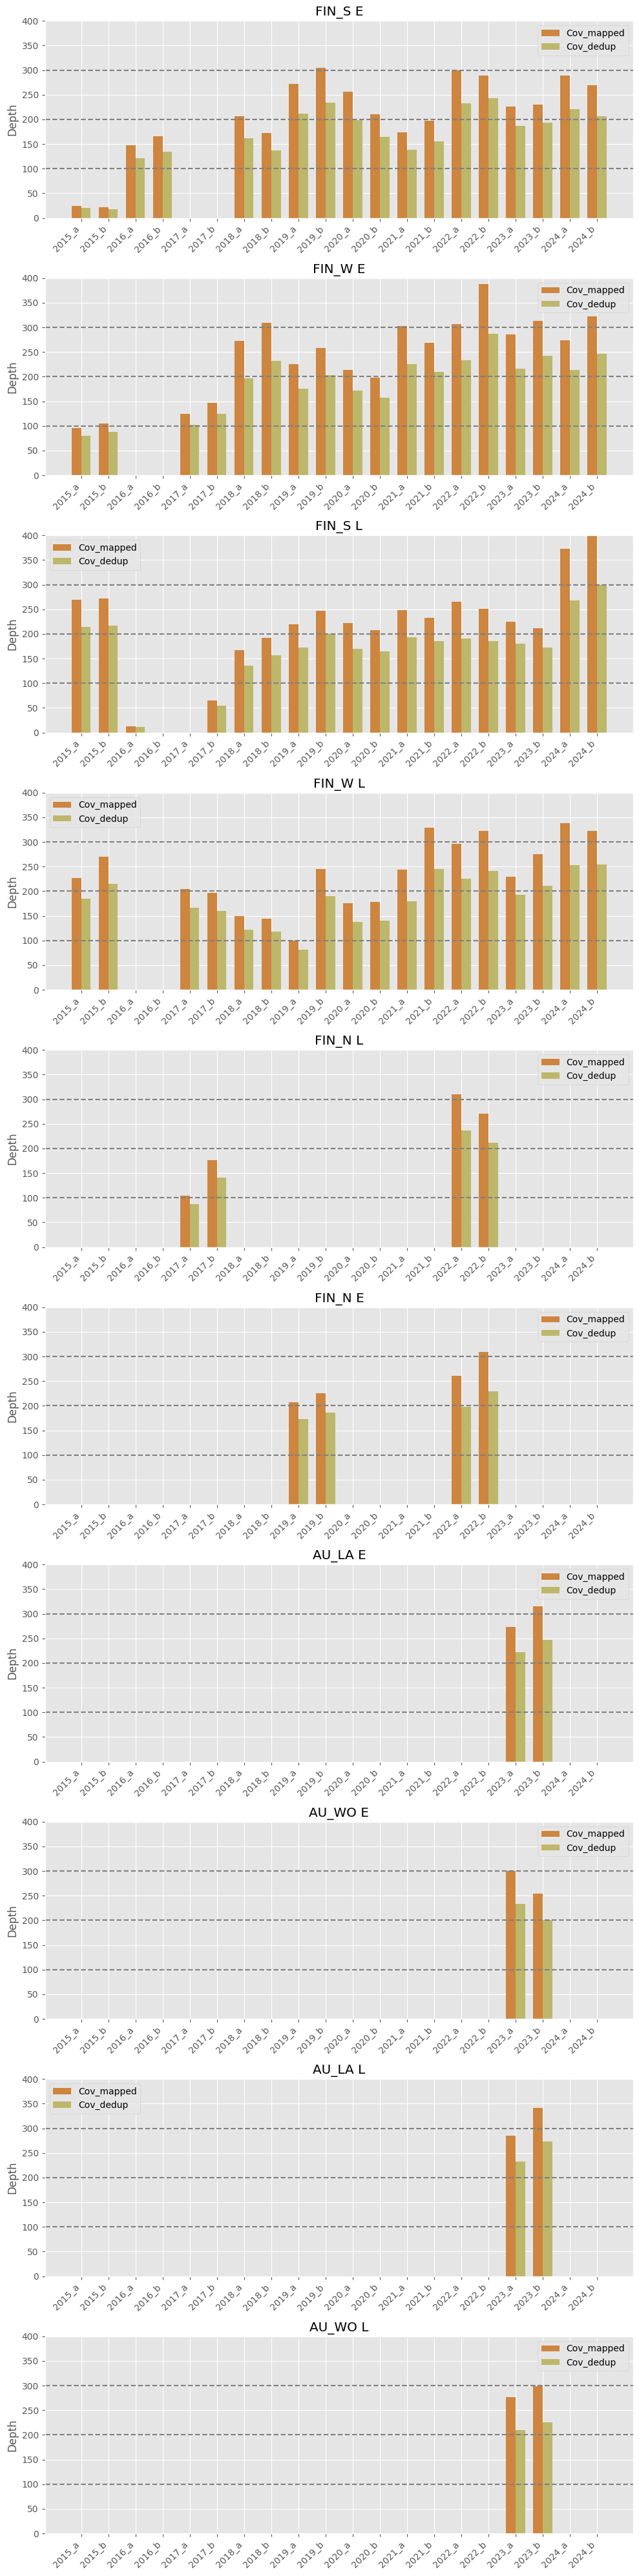

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
table = "../../results/01_proc_reads/map_reads/summary_table"
# Load data from TSV file
df = pd.read_csv(table, sep='\t')

# Create Plot_ID
df["Plot_ID"] = df["Time"] + "_" + df["Country"] + "_" + df["Region"]

# Melt into long format
df_melted = df.melt(
    id_vars=["Plot_ID", "Year", "Rep"],
    value_vars=["Cov_mapped", "Cov_dedup"],
    var_name="CoverageType",
    value_name="Coverage"
)

# Define full year range and reps
all_years = list(range(2015, 2025))
all_reps = df["Rep"].unique()
all_coverage_types = ["Cov_mapped", "Cov_dedup"]
plot_ids = df_melted["Plot_ID"].unique()

# Create subplots
n_plots = len(plot_ids)
fig, axes = plt.subplots(n_plots, 1, figsize=(10, 4 * n_plots), sharex=False)
if n_plots == 1:
    axes = [axes]

for ax, plot_id in zip(axes, plot_ids):
    # Subset for this Plot_ID
    subset = df_melted[df_melted["Plot_ID"] == plot_id]

    # Create full index for this plot
    full_index = pd.MultiIndex.from_product(
        [all_years, all_reps, all_coverage_types],
         names=["Year", "Rep", "CoverageType"]
    )
    full_df = pd.DataFrame(index=full_index).reset_index()
    full_df["Plot_ID"] = plot_id

    # Merge with actual data
    merged = pd.merge(
        full_df,
        subset,
        on=["Plot_ID", "Year", "Rep", "CoverageType"],
        how="left"
    )

    # Fill NaN Coverage with 0 (so empty bars show as zero)
    merged["Coverage"] = merged["Coverage"].fillna(0)

    # Pivot for bar plotting
    pivot = merged.pivot_table(
        index=["Year", "Rep"],
        columns="CoverageType",
        values="Coverage"
    ).reset_index()

    # Sort and label
    pivot = pivot.sort_values(["Year", "Rep"])
    labels = pivot["Year"].astype(str) + "_" + pivot["Rep"]
    x = range(len(pivot))
    width = 0.35

    # Plot bars
    ax.bar([i - width/2 for i in x], pivot["Cov_mapped"], width=width, label="Cov_mapped", color="peru")
    ax.bar([i + width/2 for i in x], pivot["Cov_dedup"], width=width, label="Cov_dedup", color="darkkhaki")

    # Labels and layout
    country = plot_id.split("_")[1]
    region = plot_id.split("_")[2]
    time = plot_id.split("_")[0]
    ax.set_title(f"{country}_{region} {time}")
    ax.set_ylabel("Depth")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylim(0, 400)
    ax.axhline(100, color='gray', linestyle='--')
    ax.axhline(200, color='gray', linestyle='--')
    ax.axhline(300, color='gray', linestyle='--')
    ax.legend()

plt.style.use("ggplot")
fig.tight_layout()
plt.show()



